In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/nlp_final_project_fastformer/

/content/drive/MyDrive/nlp_final_project_fastformer


### Load packages and config

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.1 MB/s 
     |████████████████████████████████| 182 kB 96.1 MB/s 
     |████████████████████████████████| 7.6 MB 83.0 MB/s 


In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 14.2 MB/s 
     |████████████████████████████████| 212 kB 75.9 MB/s 
     |████████████████████████████████| 115 kB 59.3 MB/s 
     |████████████████████████████████| 127 kB 77.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [1]:
import torch
import torch.nn.functional as F
from torch import nn, einsum
import numpy as np
from sklearn.metrics import *
from tqdm import tqdm
from datasets import load_dataset
from nltk.tokenize import wordpunct_tokenize
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertSelfOutput, BertIntermediate, BertOutput
from random import shuffle
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import *

In [2]:
config=BertConfig.from_json_file('fastformer.json')

### Load pretrain embedding

In [5]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !ls -lat

In [6]:
class WordEmbeddings:
    """
    Wraps an Indexer and a list of 1-D numpy arrays where each position in the list is the vector for the corresponding
    word in the indexer. The 0 vector is returned if an unknown word is queried.
    """
    def __init__(self, word_indexer, vectors):
        self.word_indexer = word_indexer
        self.vectors = vectors

    def get_initialized_embedding_layer(self):
        return torch.nn.Embedding.from_pretrained(torch.FloatTensor(self.vectors))

    def get_embedding_length(self):
        return len(self.vectors[0])

    # def get_embedding(self, word):
    def get_embedding(self, word_idx):
        """
        Returns the embedding for a given word
        :param word: The word to look up
        :return: The UNK vector if the word is not in the Indexer or the vector otherwise
        """
        # word_idx = self.word_indexer.index_of(word)
        if word_idx != -1:
            return self.vectors[word_idx]
        else:
            return self.vectors[self.word_indexer.index_of("UNK")]


In [7]:
def read_word_embeddings(embeddings_file: str) -> WordEmbeddings:
    """
    Loads the given embeddings (ASCII-formatted) into a WordEmbeddings object. Augments this with an UNK embedding
    that is the 0 vector. Reads in all embeddings with no filtering -- you should only use this for relativized
    word embedding files.
    :param embeddings_file: path to the file containing embeddings
    :return: WordEmbeddings object reflecting the words and their embeddings
    """
    f = open(embeddings_file)
    word_indexer = Indexer()
    vectors = []
    # Make position 0 a PAD token, which can be useful if you
    word_indexer.add_and_get_index("PAD")
    # Make position 1 the UNK token
    word_indexer.add_and_get_index("UNK")
    for line in f:
        if line.strip() != "":
            space_idx = line.find(' ')
            word = line[:space_idx]
            numbers = line[space_idx+1:]
            float_numbers = [float(number_str) for number_str in numbers.split()]
            vector = np.array(float_numbers)
            word_indexer.add_and_get_index(word)
            # Append the PAD and UNK vectors to start. Have to do this weirdly because we need to read the first line
            # of the file to see what the embedding dim is
            if len(vectors) == 0:
                vectors.append(np.zeros(vector.shape[0]))
                vectors.append(np.zeros(vector.shape[0]))
            vectors.append(vector)
    f.close()
    print("Read in " + repr(len(word_indexer)) + " vectors of size " + repr(vectors[0].shape[0]))
    # Turn vectors into a 2-D numpy array
    return WordEmbeddings(word_indexer, np.array(vectors))

In [68]:
word_embeddings = read_word_embeddings("glove.6B.50d.txt")

Read in 400002 vectors of size 50


In [11]:
word_embeddings_100 = read_word_embeddings("glove.6B.100d.txt")

Read in 400002 vectors of size 100


In [12]:
word_embeddings_200 = read_word_embeddings("glove.6B.200d.txt")

Read in 400002 vectors of size 200


In [13]:
word_embeddings_300 = read_word_embeddings("glove.6B.300d.txt")

Read in 400002 vectors of size 300


### Build Fastformer Model

In [9]:
config=BertConfig.from_json_file('fastformer.json')

In [10]:
class AttentionPooling(nn.Module):
    def __init__(self, config):
        self.config = config
        super(AttentionPooling, self).__init__()
        self.att_fc1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.att_fc2 = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_weights)
        
    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
            
                
    def forward(self, x, attn_mask=None):
        bz = x.shape[0]
        e = self.att_fc1(x)
        e = nn.Tanh()(e)
        alpha = self.att_fc2(e)
        alpha = torch.exp(alpha)
        if attn_mask is not None:
            alpha = alpha * attn_mask.unsqueeze(2)
        alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)
        x = torch.bmm(x.permute(0, 2, 1), alpha)
        x = torch.reshape(x, (bz, -1))  
        return x

In [11]:
class AdditiveAttention(nn.Module):
    def __init__(self, config):
        super(AdditiveAttention, self).__init__()
        self.config = config

        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" %
                (config.hidden_size, config.num_attention_heads))
            
        self.attention_head_size = int(config.hidden_size /config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.emb_dim = config.hidden_size
#         self.emb_dim = 50

        self.query = nn.Linear(self.emb_dim, self.all_head_size)
        self.query_att = nn.Linear(self.all_head_size, self.num_attention_heads)

        self.key = nn.Linear(self.emb_dim, self.all_head_size)
        self.key_att = nn.Linear(self.all_head_size, self.num_attention_heads)

        self.value = nn.Linear(self.emb_dim, self.all_head_size)

        self.transform = nn.Linear(self.all_head_size, self.all_head_size)

        self.softmax = nn.Softmax(dim=-1)
        
        self.apply(self.init_weights)

        self.param_sharing = config.param_sharing

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
                
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads,self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, input, attention_mask):
        # input:(batch_size, seq_len, emb_dim)
        batch_size, seq_len, _ = input.shape

        # concatenated Q matrix for all heads (batch_size, seq_len, all_head_size)
        concat_Q = self.query(input)
        # concatenated K matrix for all heads (batch_size, seq_len, all_head_size)
        concat_K = self.key(input)

        # (batch_size, num_head, seq_len)
        query_for_score = self.query_att(concat_Q).transpose(1, 2) / self.attention_head_size**0.5
        # add attention mask
        query_for_score += attention_mask

        # the weight alpha : (batch_size, num_head, 1, seq_len)
        query_weight = self.softmax(query_for_score).unsqueeze(2)

        # (batch_size, num_head, seq_len, head_dim)
        byhead_Q = self.transpose_for_scores(concat_Q)
        # weighted sum of q, get the global representation of q 
        # after transpose: (batch_size, 1, num_head, head_dim)
        # after view: (batch_size, 1, num_head* head_dim)
        global_q = torch.matmul(query_weight, byhead_Q).transpose(1, 2).view(-1,1,self.num_attention_heads*self.attention_head_size)
        # (batch_size, seq_len, num_head* head_dim)
        global_q_matrix = global_q.repeat(1, seq_len,1)
        

        # global q dot product with k (batch_size, seq_len, all_head_size)
        P = concat_K * global_q_matrix
        # (batch_size, num_head, seq_len)
        P_for_score = (self.key_att(P)/ self.attention_head_size**0.5).transpose(1, 2)
        # add attention mask
        P_for_score +=attention_mask

        # the weight beta (batch_size, num_head, 1, seq_len)
        query_key_weight = self.softmax(P_for_score).unsqueeze(2)
        # (batch_size, num_head, seq_len, head_dim)
        byhead_P = self.transpose_for_scores(P)
        # (batch_size, num_head, 1, head_dim)
        global_k = torch.matmul(query_key_weight, byhead_P)

        if self.param_sharing:
            # query-value parameter sharing
            # (batch_size, num_head, 1, head_dim) (batch_size, num_head, seq_len, head_dim) -> (batch_size, num_head, seq_len, head_dim)
            # after transpose: (batch_size, seq_len, num_head,  head_dim)
            weighted_value =(global_k * byhead_Q).transpose(1, 2)

        else:
            # without query value param sharing
            concat_V = self.value(input)
            byhead_V = self.transpose_for_scores(concat_V)

            weighted_value =(global_k * byhead_V).transpose(1, 2)


        # (batch_size, seq_len, num_head*head_dim)
        weighted_value = weighted_value.reshape(weighted_value.size()[:-2] + (self.num_attention_heads * self.attention_head_size,))
        # add the original Q as a residual
        weighted_value = self.transform(weighted_value) + concat_Q
      
        return weighted_value

In [12]:
class FastAttention(nn.Module):
    def __init__(self, config):
        super(FastAttention, self).__init__()
        self.self = AdditiveAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output

class FastformerLayer(nn.Module):
    def __init__(self, config):
        super(FastformerLayer, self).__init__()
        self.attention = FastAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class FastformerEncoder(nn.Module):
    def __init__(self, config, pooler_count=1):
        super(FastformerEncoder, self).__init__()
        self.config = config
        self.encoders = nn.ModuleList([FastformerLayer(config) for _ in range(config.num_hidden_layers)])
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
#         self.position_embeddings = nn.Embedding(config.max_position_embeddings, 50)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # support multiple different poolers with shared bert encoder.
        self.poolers = nn.ModuleList()
        if config.pooler_type == 'weightpooler':
            for _ in range(pooler_count):
                self.poolers.append(AttentionPooling(config))
        # logging.info(f"This model has {len(self.poolers)} poolers.")

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, 
                input_embs, 
                attention_mask, 
                pooler_index=0):
        #input_embs: batch_size, seq_len, emb_dim
        #attention_mask: batch_size, seq_len, emb_dim

        extended_attention_mask = attention_mask.unsqueeze(1)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        batch_size, seq_length, emb_dim = input_embs.shape
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_embs.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = input_embs + position_embeddings
        
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        #print(embeddings.size())
        all_hidden_states = [embeddings]

        for i, layer_module in enumerate(self.encoders):
            layer_outputs = layer_module(all_hidden_states[-1], extended_attention_mask)
            all_hidden_states.append(layer_outputs)
        assert len(self.poolers) > pooler_index
        output = self.poolers[pooler_index](all_hidden_states[-1], attention_mask)

        return output 

In [13]:
class Model(torch.nn.Module):

    def __init__(self,config,outclasses,num_tokens):
        super(Model, self).__init__()
        self.config = config
        self.word_embedding = nn.Embedding(num_tokens,config.hidden_size,padding_idx=0)
        self.fastformer_model = FastformerEncoder(config)
        self.dense_linear = nn.Linear(config.hidden_size,outclasses)
        self.criterion = nn.CrossEntropyLoss() 
        self.apply(self.init_weights)
        
    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
    
    def forward(self,input_ids,targets):
        mask=input_ids.bool().float()
        embds=self.word_embedding(input_ids)
        text_vec = self.fastformer_model(embds,mask)
        score = self.dense_linear(text_vec)
        loss = self.criterion(score, targets) 
        return loss, score

In [14]:
class Model_pretrained_emb(torch.nn.Module):

    def __init__(self,config,outclasses,embeddings: word_embeddings,pretrained_emb_dim):
        super(Model_pretrained_emb, self).__init__()
        self.config = config
        # self.word_embedding = nn.Embedding(num_tokens,config.hidden_size,padding_idx=0)
        self.word_embedding = embeddings
        self.transform = nn.Linear(pretrained_emb_dim,config.hidden_size)
        self.fastformer_model = FastformerEncoder(config)
        self.dense_linear = nn.Linear(config.hidden_size,outclasses)
        self.criterion = nn.CrossEntropyLoss() 
        self.apply(self.init_weights)
        
    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
    
    def forward(self,input_ids,targets):

        
        mask = input_ids.bool().float()


        batch_emb = []
        for batch in range(len(input_ids)):
          embds = []
          for word in input_ids[batch]:
              embds.append(self.word_embedding.get_embedding(word))
          batch_emb.append(embds)

        embds_tensor = torch.FloatTensor(np.array(batch_emb)).cuda()

        trans_embds = self.transform(embds_tensor)

        text_vec = self.fastformer_model(trans_embds,mask)
        score = self.dense_linear(text_vec)
        loss = self.criterion(score, targets) 
        return loss, score

### Build training and testing function

In [15]:
def acc(y_true, y_hat):
    y_hat = torch.argmax(y_hat, dim=-1)
    tot = y_true.shape[0]
    hit = torch.sum(y_true == y_hat)
    return hit.data.float() * 1.0 / tot

In [16]:
# def train(epochs, data, label, train_index, val_index):

#     for epoch in range(epochs):
        
#         shuffle(train_index)
#         loss = 0.0
#         accuary = 0.0
#         train_acc = []
#         train_loss = []
#         train_allpred = []

#         for cnt in range(len(train_index)//64):

#             log_ids = data[train_index][cnt*64:cnt*64+64,:256]
#             targets = label[train_index][cnt*64:cnt*64+64]

#             log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
#             targets = torch.LongTensor(targets).cuda(non_blocking=True)

#             bz_loss, y_hat = model(log_ids, targets)
#             train_allpred += y_hat.to('cpu').detach().numpy().tolist()

#             loss += bz_loss.data.float()
#             accuary += acc(targets, y_hat)

#             train_loss.append(bz_loss.data.float())
#             train_acc.append(accuary)

            
#             unified_loss=bz_loss

#             optimizer.zero_grad()
#             unified_loss.backward()
#             optimizer.step()

#             if cnt % 1000 == 0:
#                 print( ' Ed: {}, train_loss: {:.5f}, acc: {:.5f}'.format(cnt * 64, loss.data / (cnt+1), accuary / (cnt+1)))

#         y_pred_train = np.argmax(train_allpred,axis=-1)
#         y_true_train = label[val_index]

#         model.eval()
        
#         allpred=[]
#         val_loss = []

#         for cnt in range(len(val_index)//64+1):
        
#             val_log_ids=news_words[val_index][cnt*64:cnt*64+64,:256]
#             val_targets= label[val_index][cnt*64:cnt*64+64]
#             val_log_ids = torch.LongTensor(val_log_ids).cuda(non_blocking=True)
#             val_targets = torch.LongTensor(val_targets).cuda(non_blocking=True)
        
#             bz_loss2, y_hat2 = model(val_log_ids, val_targets)
#             val_loss.append(bz_loss2)
#             allpred += y_hat2.to('cpu').detach().numpy().tolist()
            
#         y_pred = np.argmax(allpred,axis=-1)
#         y_true = label[val_index]

#         print('Epoch {} train loss'.format(epoch),sum(train_loss)/len(train_loss))
#         print('Epoch {} val accuracy'.format(epoch),sum(train_acc)/len(train_acc))
#         print('Epoch {} val Macro-F'.format(epoch),f1_score(y_true_train, y_pred_train ,average = 'macro'))


#         print('Epoch {} val loss'.format(epoch),sum(val_loss)/len(val_loss))
#         print('Epoch {} val accuracy'.format(epoch),accuracy_score(y_true, y_pred))
#         print('Epoch {} val Macro-F'.format(epoch),f1_score(y_true, y_pred,average = 'macro'))
        
#         model.train()

In [17]:
def train(epochs, data, label, train_index,val_index):


    train_loss_cache = []
    train_acc_cache = []
    train_f1_cache = []

    val_loss_cache = []
    val_acc_cache = []
    val_f1_cache= []

    for epoch in range(epochs):

        loss = 0.0
        accuary = 0.0

        train_allpred = []

        np.random.shuffle(train_index) 

        for cnt in range(len(train_index)//64):

            log_ids = data[train_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
            targets = label[train_index][cnt*64:cnt*64+64]

            log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
            targets = torch.LongTensor(targets).cuda(non_blocking=True)

            bz_loss, y_hat = model(log_ids, targets)
            train_allpred += y_hat.to('cpu').detach().numpy().tolist()

            loss += bz_loss.data.float()
            accuary += acc(targets, y_hat)

            unified_loss=bz_loss
            optimizer.zero_grad()
            unified_loss.backward()
            optimizer.step()

            if cnt % 200== 0:
                print( ' Ed: {}, train_loss: {:.5f}, acc: {:.5f}'.format(cnt * 64, loss.data / (cnt+1), accuary / (cnt+1)))

        y_pred_train = np.argmax(train_allpred,axis=-1)
        y_true_train = label[train_index]  

        model.eval()

        allpred=[]
        val_loss = []

        for cnt in range(len(val_index)//64+1):
        
            log_ids = data[val_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
            targets = label[val_index][cnt*64:cnt*64+64]
            log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
            targets = torch.LongTensor(targets).cuda(non_blocking=True)
        
            bz_loss2, y_hat2 = model(log_ids, targets)
            val_loss.append(bz_loss2.data.float())
            allpred+=y_hat2.to('cpu').detach().numpy().tolist()
            
        y_pred = np.argmax(allpred,axis=-1)
        y_true = label[val_index]

        # print(accuracy_score(y_true, y_pred))
        print('Epoch {} val accuracy'.format(epoch),accuracy_score(y_true, y_pred))
        print('Epoch {} val Macro-F'.format(epoch),f1_score(y_true, y_pred,average = 'macro'))

        train_loss_cache.append(loss.data / (cnt+1))
        train_acc_cache.append(accuary / (cnt+1))
        train_f1_cache.append(f1_score(y_true_train, y_pred_train ,average = 'macro'))

        val_loss_cache.append(sum(val_loss)/len(val_loss))
        val_acc_cache.append(accuracy_score(y_true, y_pred))
        val_f1_cache.append(f1_score(y_true, y_pred,average = 'macro'))

        model.train()

    cache = {'train_loss':train_loss_cache,'train_acc':train_acc_cache,'train_f1':train_f1_cache,
             'val_loss':val_loss_cache, 'val_acc':val_acc_cache, 'val_f1':val_f1_cache}
    return cache, model

In [18]:
def test(model, data, label, test_index):
    
    model.eval()
    allpred = []
    for cnt in range(len(test_index)//64+1):

        log_ids = data[test_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
        targets= label[test_index][cnt*64:cnt*64+64]
        log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
        targets = torch.LongTensor(targets).cuda(non_blocking=True)

        bz_loss3, y_hat3 = model(log_ids, targets)
#         allpred += y_hat3
        allpred += y_hat3.to('cpu').detach().numpy().tolist()

    y_pred = np.argmax(allpred,axis=-1)
    y_true = label[test_index]

    print('test accuracy',accuracy_score(y_true, y_pred))
    print('test Macro-F',f1_score(y_true, y_pred,average = 'macro'))

In [19]:
def plot_figure(with_param_sharing,without_param_sharing,labels,set):
    plt.rcParams['axes.labelsize'] = 16  # xy轴label的size
    plt.rcParams['xtick.labelsize'] = 12  # x轴ticks的size
    plt.rcParams['ytick.labelsize'] = 14  # y轴ticks的size
    # plt.rcParams['legend.fontsize'] = 12  # 图例的size


    width = 0.3  # 柱形的宽度
    x1_list = []
    x2_list = []
    for i in range(len(with_param_sharing)):
        x1_list.append(i)
        x2_list.append(i + width)


    fig, ax1 = plt.subplots()


    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 0.6)
    a1 = ax1.bar(x1_list, with_param_sharing, width=width, color='lightcoral', align='edge', label = 'w/ param share')

    ax1.set_xticklabels(ax1.get_xticklabels()) 
    ax1.set_title('Accuracy and Macro-F on {} set'.format(set),fontsize = 14)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Macro-F')
    ax2.set_ylim(0, 0.6)
    a2 = ax2.bar(x2_list, without_param_sharing, width=width, color='lightblue', align='edge', tick_label=labels,label = 'w/o param share ')


    plt.legend(handles = [a1,a2])
    plt.tight_layout()

    plt.show()

### Yelp Fine Grained

In [20]:
dataset = load_dataset('yelp_review_full')

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to C:/Users/You Wang/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [64]:
text=[]
label=[]
for row in dataset['train']['text'][:40000]+dataset['test']['text'][:10000]:
    text.append(wordpunct_tokenize(row.lower()))
for row in dataset['train']['label'][:40000]+dataset['test']['label'][:10000]:
    label.append(row)

In [55]:
len(label)

700000

In [65]:
new_text = []
for sample in text:
    sample = sample[:512]
    new_text.append(sample+['PAD']*(512-len(sample)))

In [66]:
new_text[0]

['dr',
 '.',
 'goldberg',
 'offers',
 'everything',
 'i',
 'look',
 'for',
 'in',
 'a',
 'general',
 'practitioner',
 '.',
 'he',
 "'",
 's',
 'nice',
 'and',
 'easy',
 'to',
 'talk',
 'to',
 'without',
 'being',
 'patronizing',
 ';',
 'he',
 "'",
 's',
 'always',
 'on',
 'time',
 'in',
 'seeing',
 'his',
 'patients',
 ';',
 'he',
 "'",
 's',
 'affiliated',
 'with',
 'a',
 'top',
 '-',
 'notch',
 'hospital',
 '(',
 'nyu',
 ')',
 'which',
 'my',
 'parents',
 'have',
 'explained',
 'to',
 'me',
 'is',
 'very',
 'important',
 'in',
 'case',
 'something',
 'happens',
 'and',
 'you',
 'need',
 'surgery',
 ';',
 'and',
 'you',
 'can',
 'get',
 'referrals',
 'to',
 'see',
 'specialists',
 'without',
 'having',
 'to',
 'see',
 'him',
 'first',
 '.',
 'really',
 ',',
 'what',
 'more',
 'do',
 'you',
 'need',
 '?',
 'i',
 "'",
 'm',
 'sitting',
 'here',
 'trying',
 'to',
 'think',
 'of',
 'any',
 'complaints',
 'i',
 'have',
 'about',
 'him',
 ',',
 'but',
 'i',
 "'",
 'm',
 'really',
 'drawing'

In [69]:
new_text_index = []
for i in range(len(new_text)):
    new_text_index.append([word_embeddings.word_indexer.index_of(word) for word in new_text[i]])

In [74]:
len(new_text_index[0])

512

In [75]:
for i in range(len(new_text_index)):
    if len(new_text_index[i]) != 512:
        print(i)

In [77]:
data = np.array(new_text_index, dtype='int32')
label = np.array(label, dtype='int32')

In [78]:
np.save("yelp_data.npy",data)
np.save("yelp_label.npy",label)

### Try Ag_news dataset as example

In [ ]:
# dataset = load_dataset('ag_news')

# text=[]
# label=[]
# for row in dataset['train']['text']+dataset['test']['text']:
#     text.append(wordpunct_tokenize(row.lower()))
# for row in dataset['train']['label']+dataset['test']['label']:
#     label.append(row)

# word_dict={'PADDING':0}
# for sent in text:    
#     for token in sent:        
#         if token not in word_dict:
#             word_dict[token]=len(word_dict)

# news_words = []
# for sent in text:       
#     sample=[]
#     for token in sent:     
#         sample.append(word_dict[token])
#     sample = sample[:256]
#     news_words.append(sample+[0]*(256-len(sample)))

# news_words=np.array(news_words,dtype='int32') 
# label=np.array(label,dtype='int32') 

# index=np.arange(len(label))
# train_index=index[:120000]
# np.random.shuffle(train_index)
# test_index=index[120000:]

In [ ]:
# word_dict

In [ ]:
# model = Model(config,outclasses = 4)
# import torch.optim as optim
# optimizer = optim.Adam([ {'params': model.parameters(), 'lr': 1e-3}])
# model.cuda()

In [ ]:
# for epoch in range(2):

#     loss = 0.0
#     accuary = 0.0
    
#     for cnt in range(len(train_index)//64):

#         log_ids=news_words[train_index][cnt*64:cnt*64+64,:256]
#         targets= label[train_index][cnt*64:cnt*64+64]

#         log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
#         targets = torch.LongTensor(targets).cuda(non_blocking=True)
#         bz_loss, y_hat = model(log_ids, targets)
#         loss += bz_loss.data.float()
#         accuary += acc(targets, y_hat)
#         unified_loss=bz_loss
#         optimizer.zero_grad()
#         unified_loss.backward()
#         optimizer.step()

#         if cnt % 100== 0:
#             print( ' Ed: {}, train_loss: {:.5f}, acc: {:.5f}'.format(cnt * 64, loss.data / (cnt+1), accuary / (cnt+1)))
            
#     model.eval()
#     allpred=[]
#     for cnt in range(len(test_index)//64+1):
    
#         log_ids=news_words[test_index][cnt*64:cnt*64+64,:256]
#         targets= label[test_index][cnt*64:cnt*64+64]
#         log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
#         targets = torch.LongTensor(targets).cuda(non_blocking=True)
    
#         bz_loss2, y_hat2 = model(log_ids, targets)
#         allpred+=y_hat2.to('cpu').detach().numpy().tolist()
        
#     y_pred=np.argmax(allpred,axis=-1)
#     y_true=label[test_index]

#     print(accuracy_score(y_true, y_pred))
#     model.train()

In [ ]:
# !nvidia-smi

### Train and Test on Amazon Review dataset

In [ ]:
amazon_data = np.load('amazon_review_data.npy')
amazon_label = np.load('amazon_review_label.npy')
amazon_number_token = int(np.load('amazon_review_num_tokens.npy'))

In [ ]:
amazon_train_index = [i for i in range(40000)]
amazon_val_index = [i for i in range(40000,45000)]
amazon_test_index = [i for i in range(45000,50000)]

In [ ]:
model = Model(config,outclasses = 5,num_tokens=amazon_number_token)
optimizer = optim.Adam([ {'params': model.parameters(), 'lr': 1e-3}])
model.cuda()

In [ ]:
amazon_cache,model = train(epochs = 2, 
                           data = amazon_data , 
                           label = amazon_label,
                           train_index =  amazon_train_index,
                           val_index = amazon_val_index)

# torch.save({'metrics_cache': amazon_cache,
#             'model_dict': model.state_dict()
#             }, '/content/drive/MyDrive/nlp_final_project_fastformer/amazon_paramsharing={}.pt'.format(config.param_sharing))

#### Result for amazon review dataset

with parameter sharing:

val acc: 0.4368

val macro-F: 0.42054310427388086 


without parameter sharing:

val accuracy 0.442

val Macro-F 0.4448873549402369

In [ ]:
# with parameter sharing:
# val acc: 0.4368
# val macro-F: 0.42054310427388086

# without parameter sharing:
# val accuracy 0.442
# val Macro-F 0.4448873549402369

In [ ]:
with_param_sharing = [0.4368,0.42054310427388086]
without_param_sharing = [0.442,0.444873549402369] 
labels =['Accuracy', 'Macro-F']

plot_figure(with_param_sharing,without_param_sharing,labels,set = 'validation')

In [ ]:
test(model, amazon_data, amazon_label, amazon_test_index)

with parameter sharing:

test acc: 0.4318

test macro-F: 0.41902546679396446

without parameter sharing:

test acc: 0.4346

test macro-F:0.43726128296759664

In [ ]:
# with parameter sharing:
# test acc: 0.4318
# test macro-F: 0.41902546679396446

# without parameter sharing:
# test acc: 0.4346
# test macro-F:0.43726128296759664

In [ ]:
test_with = [0.4318,0.41902546679396446]
test_without = [0.4346,0.43726128296759664]
plot_figure(test_with,test_without,labels,'test')

In [ ]:
# for epoch in range(2):

#     loss = 0.0
#     accuary = 0.0
#     shuffle(amazon_train_index) 
#     # np.random.shuffle(amazon_train_index) 

#     for cnt in range(len(amazon_train_index)//64):

#         log_ids=amazon_data[amazon_train_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
#         targets= amazon_label[amazon_train_index][cnt*64:cnt*64+64]

#         log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
#         targets = torch.LongTensor(targets).cuda(non_blocking=True)

#         bz_loss, y_hat = model(log_ids, targets)

#         loss += bz_loss.data.float()
#         accuary += acc(targets, y_hat)

#         unified_loss=bz_loss
#         optimizer.zero_grad()
#         unified_loss.backward()
#         optimizer.step()

#         if cnt % 200 == 0:
#             print( ' Ed: {}, train_loss: {:.5f}, acc: {:.5f}'.format(cnt * 64, loss.data / (cnt+1), accuary / (cnt+1)))
            
#     model.eval()
#     allpred=[]
#     for cnt in range(len(amazon_val_index)//64+1):
    
#         log_ids = amazon_data[amazon_val_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
#         targets = amazon_label[amazon_val_index][cnt*64:cnt*64+64]
#         log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
#         targets = torch.LongTensor(targets).cuda(non_blocking=True)
    
#         bz_loss2, y_hat2 = model(log_ids, targets)
#         allpred+=y_hat2.to('cpu').detach().numpy().tolist()
        
#     y_pred = np.argmax(allpred,axis=-1)
#     y_true = amazon_label[amazon_val_index]

#     print(accuracy_score(y_true, y_pred))
#     print(f1_score(y_true, y_pred,average = 'macro'))
#     model.train()

### Train and test on IMDB review data

In [ ]:
imdb_data = np.load('imdb_data.npy')
imdb_label = np.load('imdb_label.npy')
imdb_label = imdb_label - 1
imdb_number_token = int(np.load('imdb_num_tokens.npy'))

In [ ]:
imdb_train_index = [i for i in range(108544)]
imdb_val_index = [i for i in range(108544,122106)]
imdb_test_index = [i for i in range(122106,135669)]

In [ ]:
model = Model(config, outclasses = 10, num_tokens=imdb_number_token)
optimizer = optim.Adam([ {'params': model.parameters(), 'lr': 1e-3}])
model.cuda()

Model(
  (word_embedding): Embedding(1008551, 128, padding_idx=0)
  (fastformer_model): FastformerEncoder(
    (encoders): ModuleList(
      (0): FastformerLayer(
        (attention): FastAttention(
          (self): AdditiveAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (query_att): Linear(in_features=128, out_features=8, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (key_att): Linear(in_features=128, out_features=8, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (transform): Linear(in_features=128, out_features=128, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.3, inplace=False)
          )
        )
 

In [ ]:
imdb_cache,model = train(epochs = 2, 
                           data = imdb_data , 
                           label = imdb_label,
                           train_index =  imdb_train_index,
                           val_index = imdb_val_index)

#### Result for IMDB review dataset

with parameter sharing:

val acc: 0.5287568205279457

val macro-F: 0.3128399757796875

without parameter sharing:

val accuracy 0.5306739418964754

val Macro-F 0.300849803976839

In [ ]:
with_param_sharing = [0.5287568205279457, 0.3128399757796875]
without_param_sharing = [0.5306739418964754, 0.300849803976839] 
labels =['Accuracy', 'Macro-F']

plot_figure(with_param_sharing,without_param_sharing,labels,set = 'validation')

In [ ]:
test(model, imdb_data, imdb_label, imdb_test_index)

with parameter sharing:

test acc: 0.3290569932905699

test macro-F: 0.2749917473290363

without parameter sharing:

test acc: 0.32573914325739145

test macro-F:0.2660609692557747

In [ ]:
test_with = [ 0.3290569932905699, 0.2749917473290363]
test_without = [ 0.32573914325739145, 0.2660609692557747]
plot_figure(test_with,test_without,labels,'test')

### Try models with pretrained word embedding

#### Data and Train

In [ ]:
# class Model(torch.nn.Module):

#     def __init__(self,config,outclasses,num_tokens):
#         super(Model, self).__init__()
#         self.config = config
#         self.word_embedding = nn.Embedding(num_tokens,config.hidden_size,padding_idx=0)
#         self.fastformer_model = FastformerEncoder(config)
#         self.dense_linear = nn.Linear(config.hidden_size,outclasses)
#         self.criterion = nn.CrossEntropyLoss() 
#         self.apply(self.init_weights)
        
#     def init_weights(self, module):
#         if isinstance(module, (nn.Linear, nn.Embedding)):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
#                 with torch.no_grad():
#                     module.weight[module.padding_idx].fill_(0)
#         if isinstance(module, nn.Linear) and module.bias is not None:
#             module.bias.data.zero_()
    
#     def forward(self,input_ids,targets):
#         mask=input_ids.bool().float()
#         embds=self.word_embedding(input_ids)
#         text_vec = self.fastformer_model(embds,mask)
#         score = self.dense_linear(text_vec)
#         loss = self.criterion(score, targets) 
#         return loss, score

In [ ]:
# class Model_pretrained_emb(torch.nn.Module):

#     def __init__(self,config,outclasses,embeddings: word_embeddings ):
#         super(Model_pretrained_emb, self).__init__()
#         self.config = config
#         # self.word_embedding = nn.Embedding(num_tokens,config.hidden_size,padding_idx=0)
#         self.word_embedding = embeddings
#         self.transform = nn.Linear(50,config.hidden_size)
#         self.fastformer_model = FastformerEncoder(config)
#         self.dense_linear = nn.Linear(config.hidden_size,outclasses)
#         self.criterion = nn.CrossEntropyLoss() 
#         self.apply(self.init_weights)
        
#     def init_weights(self, module):
#         if isinstance(module, (nn.Linear, nn.Embedding)):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
#                 with torch.no_grad():
#                     module.weight[module.padding_idx].fill_(0)
#         if isinstance(module, nn.Linear) and module.bias is not None:
#             module.bias.data.zero_()
    
#     def forward(self,input_ids,targets):

        
#         mask = input_ids.bool().float()


#         batch_emb = []
#         for batch in range(len(input_ids)):
#           embds = []
#           for word in input_ids[batch]:
#               embds.append(word_embeddings.get_embedding(word))
#           batch_emb.append(embds)

#         embds_tensor = torch.FloatTensor(np.array(batch_emb)).cuda()

#         trans_embds = self.transform(embds_tensor)

#         text_vec = self.fastformer_model(trans_embds,mask)
#         score = self.dense_linear(text_vec)
#         loss = self.criterion(score, targets) 
#         return loss, score

In [ ]:
# word_embeddings.word_indexer.index_of('word')
# input_ids= [word_embeddings.word_indexer.index_of(word) for word in ex_words]
# len(word_embeddings.word_indexer)

In [38]:
amazon_data_new = np.load('amazon_review_data_new_index.npy')
amazon_label_new = np.load('amazon_review_label_new_index.npy')

amazon_train_index = [i for i in range(40000)]
amazon_val_index = [i for i in range(40000,45000)]
amazon_test_index = [i for i in range(45000,50000)]

In [124]:
def train(model,epochs, data, label, train_index,val_index):


    train_loss_cache = []
    train_acc_cache = []
    train_f1_cache = []

    val_loss_cache = []
    val_acc_cache = []
    val_f1_cache= []

    for epoch in range(epochs):

        loss = 0.0
        accuary = 0.0

        train_allpred = []

        np.random.shuffle(train_index) 

        for cnt in range(len(train_index)//64):

            log_ids = data[train_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
            targets = label[train_index][cnt*64:cnt*64+64]

            log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
            targets = torch.LongTensor(targets).cuda(non_blocking=True)

            bz_loss, y_hat = model(log_ids, targets)
            train_allpred += y_hat.to('cpu').detach().numpy().tolist()

            loss += bz_loss.data.float()
            accuary += acc(targets, y_hat)

            unified_loss=bz_loss
            optimizer.zero_grad()
            unified_loss.backward()
            optimizer.step()

            if cnt % 200== 0:
                print( ' Ed: {}, train_loss: {:.5f}, acc: {:.5f}'.format(cnt * 64, loss.data / (cnt+1), accuary / (cnt+1)))

        y_pred_train = np.argmax(train_allpred,axis=-1)
        y_true_train = label[train_index]  

        model.eval()

        allpred=[]
        val_loss = []

        for cnt in range(len(val_index)//64+1):
        
            log_ids = data[val_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
            targets = label[val_index][cnt*64:cnt*64+64]
            log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
            targets = torch.LongTensor(targets).cuda(non_blocking=True)
        
            bz_loss2, y_hat2 = model(log_ids, targets)
            val_loss.append(bz_loss2.data.float())
            allpred+=y_hat2.to('cpu').detach().numpy().tolist()
            
        y_pred = np.argmax(allpred,axis=-1)
        y_true = label[val_index]

        # print(accuracy_score(y_true, y_pred))
        print('Epoch {} val accuracy'.format(epoch),accuracy_score(y_true, y_pred))
        print('Epoch {} val Macro-F'.format(epoch),f1_score(y_true, y_pred,average = 'macro'))

        train_loss_cache.append(loss.data / (cnt+1))
        train_acc_cache.append(accuary / (cnt+1))
        train_f1_cache.append(f1_score(y_true_train, y_pred_train ,average = 'macro'))

        val_loss_cache.append(sum(val_loss)/len(val_loss))
        val_acc_cache.append(accuracy_score(y_true, y_pred))
        val_f1_cache.append(f1_score(y_true, y_pred,average = 'macro'))

        model.train()

    cache = {'train_loss':train_loss_cache,'train_acc':train_acc_cache,'train_f1':train_f1_cache,
             'val_loss':val_loss_cache, 'val_acc':val_acc_cache, 'val_f1':val_f1_cache}
    return cache, model

#### Train and Validation Results for Amazon dataset using 50-300 dimension glove 

In [ ]:
pretrained_emb_dim = 50
model_50d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings,pretrained_emb_dim = pretrained_emb_dim)
optimizer = optim.Adam([ {'params': model_50d.parameters(), 'lr': 1e-3}])
model_50d.cuda()

Model_pretrained_emb(
  (transform): Linear(in_features=50, out_features=256, bias=True)
  (fastformer_model): FastformerEncoder(
    (encoders): ModuleList(
      (0): FastformerLayer(
        (attention): FastAttention(
          (self): AdditiveAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (query_att): Linear(in_features=256, out_features=16, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (key_att): Linear(in_features=256, out_features=16, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (transform): Linear(in_features=256, out_features=256, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=False

In [ ]:
amazon_cache_50d,model_50d_res = train(model = model_50d, 
                                       epochs = 5, 
                                      data = amazon_data_new , 
                                      label = amazon_label_new,
                                      train_index =  amazon_train_index,
                                      val_index = amazon_val_index)

torch.save({'metrics_cache': amazon_cache_50d,
            'model_dict': model_50d_res.state_dict()
            }, '/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove50d_paramsharing={}.pt'.format(config.param_sharing))

 Ed: 0, train_loss: 1.62193, acc: 0.20312
 Ed: 12800, train_loss: 1.47836, acc: 0.32774
 Ed: 25600, train_loss: 1.44490, acc: 0.34784
 Ed: 38400, train_loss: 1.42488, acc: 0.35927
Epoch 0 val accuracy 0.3944
Epoch 0 val Macro-F 0.3650302795996608
 Ed: 0, train_loss: 1.29977, acc: 0.39062
 Ed: 12800, train_loss: 1.35630, acc: 0.40104
 Ed: 25600, train_loss: 1.34524, acc: 0.40820
 Ed: 38400, train_loss: 1.34057, acc: 0.41036
Epoch 1 val accuracy 0.4028
Epoch 1 val Macro-F 0.3670376990575944
 Ed: 0, train_loss: 1.25017, acc: 0.43750
 Ed: 12800, train_loss: 1.29669, acc: 0.42382
 Ed: 25600, train_loss: 1.28806, acc: 0.42947
 Ed: 38400, train_loss: 1.28784, acc: 0.43152
Epoch 2 val accuracy 0.417
Epoch 2 val Macro-F 0.378466553811226
 Ed: 0, train_loss: 1.13393, acc: 0.62500
 Ed: 12800, train_loss: 1.24574, acc: 0.45826
 Ed: 25600, train_loss: 1.24481, acc: 0.45484
 Ed: 38400, train_loss: 1.24877, acc: 0.45466
Epoch 3 val accuracy 0.4196
Epoch 3 val Macro-F 0.40424968374868187
 Ed: 0, train

glove50d (with paramsharing):

val acc: 0.4254

val macro-F: 0.4114999892330128



In [53]:
glove_50d_val = [0.4254, 0.4114999892330128]

In [ ]:
pretrained_emb_dim = 100
model_100d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_100,pretrained_emb_dim = pretrained_emb_dim)
optimizer = optim.Adam([ {'params': model_100d.parameters(), 'lr': 1e-3}])
model_100d.cuda()

Model_pretrained_emb(
  (transform): Linear(in_features=100, out_features=256, bias=True)
  (fastformer_model): FastformerEncoder(
    (encoders): ModuleList(
      (0): FastformerLayer(
        (attention): FastAttention(
          (self): AdditiveAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (query_att): Linear(in_features=256, out_features=16, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (key_att): Linear(in_features=256, out_features=16, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (transform): Linear(in_features=256, out_features=256, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=Fals

In [ ]:
amazon_cache_100d,model_100d_res = train(model = model_100d, 
                                       epochs = 5, 
                                      data = amazon_data_new , 
                                      label = amazon_label_new,
                                      train_index =  amazon_train_index,
                                      val_index = amazon_val_index)

torch.save({'metrics_cache': amazon_cache_100d,
            'model_dict': model_100d_res.state_dict()
            }, '/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove{}_paramsharing={}.pt'.format(pretrained_emb_dim,config.param_sharing))

 Ed: 0, train_loss: 1.62106, acc: 0.17188
 Ed: 12800, train_loss: 1.49871, acc: 0.31763
 Ed: 25600, train_loss: 1.44421, acc: 0.34963
 Ed: 38400, train_loss: 1.40950, acc: 0.36951
Epoch 0 val accuracy 0.4076
Epoch 0 val Macro-F 0.39320016643723976
 Ed: 0, train_loss: 1.38965, acc: 0.35938
 Ed: 12800, train_loss: 1.30195, acc: 0.42428
 Ed: 25600, train_loss: 1.29391, acc: 0.43119
 Ed: 38400, train_loss: 1.29014, acc: 0.43188
Epoch 1 val accuracy 0.4292
Epoch 1 val Macro-F 0.4309119114922053
 Ed: 0, train_loss: 1.26895, acc: 0.53125
 Ed: 12800, train_loss: 1.25934, acc: 0.45204
 Ed: 25600, train_loss: 1.25384, acc: 0.45340
 Ed: 38400, train_loss: 1.25418, acc: 0.45297
Epoch 2 val accuracy 0.4416
Epoch 2 val Macro-F 0.42697503834259437
 Ed: 0, train_loss: 1.11370, acc: 0.56250
 Ed: 12800, train_loss: 1.23159, acc: 0.46580
 Ed: 25600, train_loss: 1.22754, acc: 0.46630
 Ed: 38400, train_loss: 1.22769, acc: 0.46594
Epoch 3 val accuracy 0.4206
Epoch 3 val Macro-F 0.4258406156482365
 Ed: 0, tr

glove100d (with paramsharing):

val acc: 0.4442

val macro-F: 0.41687280518832087

In [54]:
glove_100d_val = [0.4442, 0.41687280518832087]

In [ ]:
pretrained_emb_dim = 200
model_200d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_200,pretrained_emb_dim = pretrained_emb_dim)
optimizer = optim.Adam([ {'params': model_200d.parameters(), 'lr': 1e-3}])
model_200d.cuda()

Model_pretrained_emb(
  (transform): Linear(in_features=200, out_features=256, bias=True)
  (fastformer_model): FastformerEncoder(
    (encoders): ModuleList(
      (0): FastformerLayer(
        (attention): FastAttention(
          (self): AdditiveAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (query_att): Linear(in_features=256, out_features=16, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (key_att): Linear(in_features=256, out_features=16, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (transform): Linear(in_features=256, out_features=256, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=Fals

In [ ]:
amazon_cache_200d,model_200d_res = train(model = model_200d, 
                                       epochs = 5, 
                                      data = amazon_data_new , 
                                      label = amazon_label_new,
                                      train_index =  amazon_train_index,
                                      val_index = amazon_val_index)

torch.save({'metrics_cache': amazon_cache_200d,
            'model_dict': model_200d_res.state_dict()
            }, '/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove{}_paramsharing={}.pt'.format(pretrained_emb_dim,config.param_sharing))

 Ed: 0, train_loss: 1.65704, acc: 0.15625
 Ed: 12800, train_loss: 1.45067, acc: 0.35634
 Ed: 25600, train_loss: 1.39450, acc: 0.38155
 Ed: 38400, train_loss: 1.36434, acc: 0.39663
Epoch 0 val accuracy 0.418
Epoch 0 val Macro-F 0.39859595663362396
 Ed: 0, train_loss: 1.24284, acc: 0.35938
 Ed: 12800, train_loss: 1.27187, acc: 0.44970
 Ed: 25600, train_loss: 1.27316, acc: 0.44564
 Ed: 38400, train_loss: 1.27160, acc: 0.44600
Epoch 1 val accuracy 0.4212
Epoch 1 val Macro-F 0.4255087297755307
 Ed: 0, train_loss: 1.15907, acc: 0.51562
 Ed: 12800, train_loss: 1.25288, acc: 0.45491
 Ed: 25600, train_loss: 1.24258, acc: 0.46068
 Ed: 38400, train_loss: 1.23819, acc: 0.46272
Epoch 2 val accuracy 0.4498
Epoch 2 val Macro-F 0.434674619166315
 Ed: 0, train_loss: 1.12367, acc: 0.56250
 Ed: 12800, train_loss: 1.20505, acc: 0.47699
 Ed: 25600, train_loss: 1.21247, acc: 0.47245
 Ed: 38400, train_loss: 1.21219, acc: 0.46995
Epoch 3 val accuracy 0.445
Epoch 3 val Macro-F 0.4500075529248474
 Ed: 0, train_

In [55]:
glove_200d_val = [0.445, 0.45]

glove200d (with paramsharing):

val acc: 0.445

val macro-F: 0.4500075529248474

In [ ]:
pretrained_emb_dim = 300
model_300d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_300,pretrained_emb_dim = pretrained_emb_dim)
optimizer = optim.Adam([ {'params': model_300d.parameters(), 'lr': 1e-3}])
model_300d.cuda()

Model_pretrained_emb(
  (transform): Linear(in_features=300, out_features=256, bias=True)
  (fastformer_model): FastformerEncoder(
    (encoders): ModuleList(
      (0): FastformerLayer(
        (attention): FastAttention(
          (self): AdditiveAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (query_att): Linear(in_features=256, out_features=16, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (key_att): Linear(in_features=256, out_features=16, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (transform): Linear(in_features=256, out_features=256, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=Fals

In [ ]:
amazon_cache_300d,model_300d_res = train(model = model_300d, 
                                       epochs = 5, 
                                      data = amazon_data_new , 
                                      label = amazon_label_new,
                                      train_index =  amazon_train_index,
                                      val_index = amazon_val_index)

torch.save({'metrics_cache': amazon_cache_300d,
            'model_dict': model_300d_res.state_dict()
            }, '/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove{}_paramsharing={}.pt'.format(pretrained_emb_dim,config.param_sharing))

 Ed: 0, train_loss: 1.62556, acc: 0.20312
 Ed: 12800, train_loss: 1.43366, acc: 0.36140
 Ed: 25600, train_loss: 1.37370, acc: 0.39281
 Ed: 38400, train_loss: 1.34635, acc: 0.40687
Epoch 0 val accuracy 0.4018
Epoch 0 val Macro-F 0.3905551365235523
 Ed: 0, train_loss: 1.25053, acc: 0.48438
 Ed: 12800, train_loss: 1.25777, acc: 0.44737
 Ed: 25600, train_loss: 1.25838, acc: 0.44880
 Ed: 38400, train_loss: 1.25332, acc: 0.45089
Epoch 1 val accuracy 0.4406
Epoch 1 val Macro-F 0.42949810155118523
 Ed: 0, train_loss: 1.11882, acc: 0.46875
 Ed: 12800, train_loss: 1.22145, acc: 0.46175
 Ed: 25600, train_loss: 1.21778, acc: 0.46614
 Ed: 38400, train_loss: 1.21804, acc: 0.46794
Epoch 2 val accuracy 0.4396
Epoch 2 val Macro-F 0.44264162801495066
 Ed: 0, train_loss: 1.11672, acc: 0.53125
 Ed: 12800, train_loss: 1.21522, acc: 0.46805
 Ed: 25600, train_loss: 1.20902, acc: 0.47144
 Ed: 38400, train_loss: 1.20427, acc: 0.47366
Epoch 3 val accuracy 0.4362
Epoch 3 val Macro-F 0.43130921719898385
 Ed: 0, t

glove300d (with paramsharing):

val acc: 0.4522

val macro-F: 0.4342004453226235

In [56]:
glove_300d_val = [0.4522, 0.4342004453226235]

In [ ]:
def test(model, data, label, test_index):
    
    model.eval()
    allpred = []
    for cnt in range(len(test_index)//64+1):

        log_ids = data[test_index][cnt*64:cnt*64+64,:config.max_position_embeddings]
        targets= label[test_index][cnt*64:cnt*64+64]
        log_ids = torch.LongTensor(log_ids).cuda(non_blocking=True)
        targets = torch.LongTensor(targets).cuda(non_blocking=True)

        bz_loss3, y_hat3 = model(log_ids, targets)
#         allpred += y_hat3
        allpred += y_hat3.to('cpu').detach().numpy().tolist()

    y_pred = np.argmax(allpred,axis=-1)
    y_true = label[test_index]

    print('test accuracy',accuracy_score(y_true, y_pred))
    print('test Macro-F',f1_score(y_true, y_pred,average = 'macro'))

#### Test Results on Amazon dataset using glove 50-300 dimension

In [25]:
model_50d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings,pretrained_emb_dim = 50)
model_100d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_100,pretrained_emb_dim = 100)
model_200d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_200,pretrained_emb_dim = 200)
model_300d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_300,pretrained_emb_dim = 300)

In [44]:
amazon_50d = torch.load('/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove50d_paramsharing=True.pt', map_location=torch.device('cpu'))

In [45]:
model_50d.load_state_dict(amazon_50d['model_dict'])

<All keys matched successfully>

In [47]:
test(model_50d.cuda(), amazon_data_new, amazon_label_new, amazon_test_index)

test accuracy 0.4096
test Macro-F 0.3971812759759611


amazon glove 50d (with paramsharing)

test accuracy 0.4096

test Macro-F 0.3971812759759611

In [57]:
glove_50d_test = [0.4096,0.3971812759759611]

In [49]:
amazon_100d = torch.load('/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove100_paramsharing=True.pt', map_location=torch.device('cpu'))
model_100d.load_state_dict(amazon_100d['model_dict'])
test(model_100d.cuda(), amazon_data_new, amazon_label_new, amazon_test_index)

test accuracy 0.4416
test Macro-F 0.4179757038579264


amazon glove 100d (with paramsharing)

test accuracy 0.4416

test Macro-F 0.4179757038579264

In [60]:
glove_100d_test = [0.4416,0.4179757038579264]

In [50]:
amazon_200d = torch.load('/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove200_paramsharing=True.pt', map_location=torch.device('cpu'))
model_200d.load_state_dict(amazon_200d['model_dict'])
test(model_200d.cuda(), amazon_data_new, amazon_label_new, amazon_test_index)

test accuracy 0.426
test Macro-F 0.3973358713447165


amazon glove 200d (with paramsharing)

test accuracy 0.426

test Macro-F 0.3973358713447165

In [61]:
glove_200d_test = [0.426,0.3973358713447165]

In [52]:
amazon_300d = torch.load('/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove300_paramsharing=True.pt', map_location=torch.device('cpu'))
model_300d.load_state_dict(amazon_300d['model_dict'])
test(model_300d.cuda(), amazon_data_new, amazon_label_new, amazon_test_index)

test accuracy 0.457
test Macro-F 0.4379391751958033


amazon glove 300d (with paramsharing)

test accuracy 0.457

test Macro-F 0.4379391751958033 

In [62]:
glove_300d_test = [0.457,0.4379391751958033]

#### Plot the validation and test result

In [117]:
def plot_figure(glove_50d,glove_100d,glove_200d,glove_300d,
                labels,set):
    plt.rcParams['axes.labelsize'] = 16  # xy轴label的size
    plt.rcParams['xtick.labelsize'] = 12  # x轴ticks的size
    plt.rcParams['ytick.labelsize'] = 14  # y轴ticks的size
    # plt.rcParams['legend.fontsize'] = 12  # 图例的size


    width = 0.15  # 柱形的宽度
    x1_list = []
    x2_list = []
    x3_list = []
    x4_list = []
    for i in range(len(glove_50d)):
        x1_list.append(i)
        x2_list.append(i + width)
        x3_list.append(i+ 2*width)
        x4_list.append(i+ 3*width)

    # plt.figure(figsize=(20, 10), dpi=80)
    fig, ax1 = plt.subplots(figsize=(8, 5))


    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 0.6)
    a1 = ax1.bar(x1_list, glove_50d, width=width, color='lightcoral', align='edge', label = 'glove_50d')
    

    ax1.set_xticklabels(ax1.get_xticklabels()) 
    ax1.set_title('Accuracy and Macro-F of Different Pretrained Embedding on {} set'.format(set),fontsize = 14)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Macro-F')
    ax2.set_ylim(0, 0.6)
    a2 = ax2.bar(x2_list, glove_100d, width=width, color='lightblue', align='edge', tick_label=labels,label = 'glove_100d')


    ax3 = ax2.twinx()
    ax3.set_ylim(0, 0.6)
    a3 = ax3.bar(x3_list, glove_200d, width=width, color='darkseagreen', align='edge', tick_label=labels,label = 'glove_200d')


    ax4 = ax3.twinx()
    ax4.set_ylim(0, 0.6)
    a4 = ax4.bar(x4_list, glove_300d, width=width, color='papayawhip', align='edge', tick_label=labels,label = 'glove_300d')

    plt.legend(handles = [a1,a2,a3,a4])
    plt.tight_layout()

    plt.show()

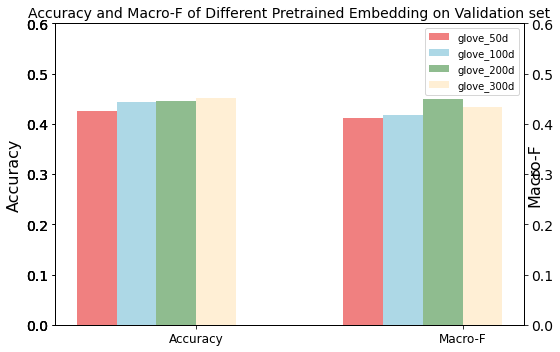

In [118]:
labels = ['Accuracy','Macro-F']
plot_figure(glove_50d_val,glove_100d_val,glove_200d_val,glove_300d_val,
                labels,'Validation')

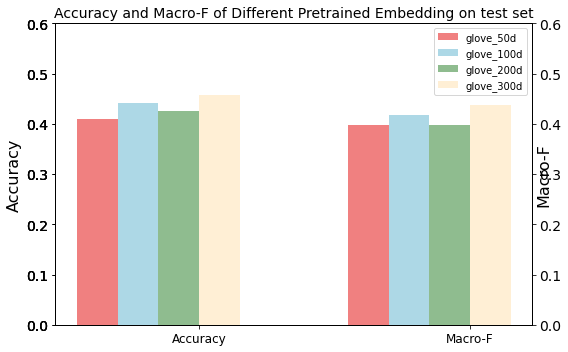

In [119]:
plot_figure(glove_50d_test,glove_100d_test,glove_200d_test,glove_300d_test,
                labels,'test')

{'train_loss': [tensor(10.6277),
  tensor(9.9152),
  tensor(9.6340),
  tensor(9.5284),
  tensor(9.3603)],
 'train_acc': [tensor(3.2326),
  tensor(3.5688),
  tensor(3.7049),
  tensor(3.7518),
  tensor(3.8398)],
 'train_f1': [0.4005200808433601,
  0.4441380658106871,
  0.46212983044961176,
  0.4682210377870617,
  0.4800923319833423],
 'val_loss': [tensor(1.3497),
  tensor(1.2703),
  tensor(1.3092),
  tensor(1.3030),
  tensor(1.2719)],
 'val_acc': [0.4018, 0.4406, 0.4396, 0.4362, 0.4522],
 'val_f1': [0.3905551365235523,
  0.42949810155118523,
  0.44264162801495066,
  0.43130921719898385,
  0.4342004453226235]}

#### Try run more epochs for glove 300d

In [122]:
pretrained_emb_dim = 300
model_300d = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings_300,pretrained_emb_dim = pretrained_emb_dim)
optimizer = optim.Adam([ {'params': model_300d.parameters(), 'lr': 1e-3}])
model_300d.cuda()

Model_pretrained_emb(
  (transform): Linear(in_features=300, out_features=256, bias=True)
  (fastformer_model): FastformerEncoder(
    (encoders): ModuleList(
      (0): FastformerLayer(
        (attention): FastAttention(
          (self): AdditiveAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (query_att): Linear(in_features=256, out_features=16, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (key_att): Linear(in_features=256, out_features=16, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (transform): Linear(in_features=256, out_features=256, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.2, inplace=Fals

In [ ]:
amazon_cache_300d,model_300d_res = train(model = model_300d, 
                                       epochs = 20, 
                                      data = amazon_data_new , 
                                      label = amazon_label_new,
                                      train_index =  amazon_train_index,
                                      val_index = amazon_val_index)

torch.save({'metrics_cache': amazon_cache_300d,
            'model_dict': model_300d_res.state_dict()
            }, '/content/drive/MyDrive/nlp_final_project_fastformer/amazon_glove{}_paramsharing={}_20epochs.pt'.format(pretrained_emb_dim,config.param_sharing))

 Ed: 0, train_loss: 1.62291, acc: 0.15625
 Ed: 12800, train_loss: 1.39947, acc: 0.37990
 Ed: 25600, train_loss: 1.35663, acc: 0.40173
 Ed: 38400, train_loss: 1.34021, acc: 0.41012
Epoch 0 val accuracy 0.4322
Epoch 0 val Macro-F 0.4272291001676498
 Ed: 0, train_loss: 1.23573, acc: 0.45312
 Ed: 12800, train_loss: 1.26895, acc: 0.44535
 Ed: 25600, train_loss: 1.25772, acc: 0.45036
 Ed: 38400, train_loss: 1.25146, acc: 0.45196
Epoch 1 val accuracy 0.4398
Epoch 1 val Macro-F 0.4412694183887772
 Ed: 0, train_loss: 1.17224, acc: 0.53125
 Ed: 12800, train_loss: 1.21546, acc: 0.47069
 Ed: 25600, train_loss: 1.22401, acc: 0.46287
 Ed: 38400, train_loss: 1.22433, acc: 0.46514
Epoch 2 val accuracy 0.4442
Epoch 2 val Macro-F 0.43202334690938243
 Ed: 0, train_loss: 1.23071, acc: 0.45312
 Ed: 12800, train_loss: 1.19973, acc: 0.47691
 Ed: 25600, train_loss: 1.19780, acc: 0.47810
 Ed: 38400, train_loss: 1.19863, acc: 0.47769
Epoch 3 val accuracy 0.4432
Epoch 3 val Macro-F 0.4342910795643259
 Ed: 0, tra

### Try without mask

In [ ]:
def acc(y_true, y_hat):
    y_hat = torch.argmax(y_hat, dim=-1)
    tot = y_true.shape[0]
    hit = torch.sum(y_true == y_hat)
    return hit.data.float() * 1.0 / tot

In [ ]:
class AttentionPooling(nn.Module):
    def __init__(self, config):
        self.config = config
        super(AttentionPooling, self).__init__()
        self.att_fc1 = nn.Linear(config.hidden_size, config.hidden_size)
        self.att_fc2 = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_weights)
        
    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
            
                
    def forward(self, x):
        bz = x.shape[0]
        e = self.att_fc1(x)
        e = nn.Tanh()(e)
        alpha = self.att_fc2(e)
        alpha = torch.exp(alpha)
        # if attn_mask is not None:
        #     alpha = alpha * attn_mask.unsqueeze(2)
        alpha = alpha / (torch.sum(alpha, dim=1, keepdim=True) + 1e-8)
        x = torch.bmm(x.permute(0, 2, 1), alpha)
        x = torch.reshape(x, (bz, -1))  
        return x

In [ ]:
class AdditiveAttention(nn.Module):
    def __init__(self, config):
        super(AdditiveAttention, self).__init__()
        self.config = config

        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" %
                (config.hidden_size, config.num_attention_heads))
            
        self.attention_head_size = int(config.hidden_size /config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.emb_dim = config.hidden_size
#         self.emb_dim = 50

        self.query = nn.Linear(self.emb_dim, self.all_head_size)
        self.query_att = nn.Linear(self.all_head_size, self.num_attention_heads)

        self.key = nn.Linear(self.emb_dim, self.all_head_size)
        self.key_att = nn.Linear(self.all_head_size, self.num_attention_heads)

        self.value = nn.Linear(self.emb_dim, self.all_head_size)

        self.transform = nn.Linear(self.all_head_size, self.all_head_size)

        self.softmax = nn.Softmax(dim=-1)
        
        self.apply(self.init_weights)

        self.param_sharing = config.param_sharing

    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
                
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads,self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, input):
        # input:(batch_size, seq_len, emb_dim)
        batch_size, seq_len, _ = input.shape

        # concatenated Q matrix for all heads (batch_size, seq_len, all_head_size)
        concat_Q = self.query(input)
        # concatenated K matrix for all heads (batch_size, seq_len, all_head_size)
        concat_K = self.key(input)

        # (batch_size, num_head, seq_len)
        query_for_score = self.query_att(concat_Q).transpose(1, 2) / self.attention_head_size**0.5
        # add attention mask
        # query_for_score += attention_mask

        # the weight alpha : (batch_size, num_head, 1, seq_len)
        query_weight = self.softmax(query_for_score).unsqueeze(2)

        # (batch_size, num_head, seq_len, head_dim)
        byhead_Q = self.transpose_for_scores(concat_Q)
        # weighted sum of q, get the global representation of q 
        # after transpose: (batch_size, 1, num_head, head_dim)
        # after view: (batch_size, 1, num_head* head_dim)
        global_q = torch.matmul(query_weight, byhead_Q).transpose(1, 2).view(-1,1,self.num_attention_heads*self.attention_head_size)
        # (batch_size, seq_len, num_head* head_dim)
        global_q_matrix = global_q.repeat(1, seq_len,1)
        

        # global q dot product with k (batch_size, seq_len, all_head_size)
        P = concat_K * global_q_matrix
        # (batch_size, num_head, seq_len)
        P_for_score = (self.key_att(P)/ self.attention_head_size**0.5).transpose(1, 2)
        # add attention mask
        # P_for_score +=attention_mask

        # the weight beta (batch_size, num_head, 1, seq_len)
        query_key_weight = self.softmax(P_for_score).unsqueeze(2)
        # (batch_size, num_head, seq_len, head_dim)
        byhead_P = self.transpose_for_scores(P)
        # (batch_size, num_head, 1, head_dim)
        global_k = torch.matmul(query_key_weight, byhead_P)

        if self.param_sharing:
            # query-value parameter sharing
            # (batch_size, num_head, 1, head_dim) (batch_size, num_head, seq_len, head_dim) -> (batch_size, num_head, seq_len, head_dim)
            # after transpose: (batch_size, seq_len, num_head,  head_dim)
            weighted_value =(global_k * byhead_Q).transpose(1, 2)

        else:
            # without query value param sharing
            concat_V = self.value(input)
            byhead_V = self.transpose_for_scores(concat_V)

            weighted_value =(global_k * byhead_V).transpose(1, 2)


        # (batch_size, seq_len, num_head*head_dim)
        weighted_value = weighted_value.reshape(weighted_value.size()[:-2] + (self.num_attention_heads * self.attention_head_size,))
        # add the original Q as a residual
        weighted_value = self.transform(weighted_value) + concat_Q
      
        return weighted_value

class FastAttention(nn.Module):
    def __init__(self, config):
        super(FastAttention, self).__init__()
        self.self = AdditiveAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor):
        self_output = self.self(input_tensor)
        attention_output = self.output(self_output, input_tensor)
        return attention_output



class FastformerLayer(nn.Module):
    def __init__(self, config):
        super(FastformerLayer, self).__init__()
        self.attention = FastAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states):
        attention_output = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class FastformerEncoder(nn.Module):
    def __init__(self, config, pooler_count=1):
        super(FastformerEncoder, self).__init__()
        self.config = config
        self.encoders = nn.ModuleList([FastformerLayer(config) for _ in range(config.num_hidden_layers)])
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
#         self.position_embeddings = nn.Embedding(config.max_position_embeddings, 50)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # support multiple different poolers with shared bert encoder.
        self.poolers = nn.ModuleList()
        if config.pooler_type == 'weightpooler':
            for _ in range(pooler_count):
                self.poolers.append(AttentionPooling(config))
        # logging.info(f"This model has {len(self.poolers)} poolers.")

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, 
                input_embs, 
                pooler_index=0):
        #input_embs: batch_size, seq_len, emb_dim
        #attention_mask: batch_size, seq_len, emb_dim

        # extended_attention_mask = attention_mask.unsqueeze(1)
        # extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        # extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        batch_size, seq_length, emb_dim = input_embs.shape
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_embs.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, -1)
        position_embeddings = self.position_embeddings(position_ids)

        embeddings = input_embs + position_embeddings
        
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        #print(embeddings.size())
        all_hidden_states = [embeddings]

        for i, layer_module in enumerate(self.encoders):
            layer_outputs = layer_module(all_hidden_states[-1])
            all_hidden_states.append(layer_outputs)
        assert len(self.poolers) > pooler_index
        output = self.poolers[pooler_index](all_hidden_states[-1])

        return output 


class Model_pretrained_emb(torch.nn.Module):

    def __init__(self,config,outclasses,embeddings: word_embeddings ):
        super(Model_pretrained_emb, self).__init__()
        self.config = config
        # self.word_embedding = nn.Embedding(num_tokens,config.hidden_size,padding_idx=0)
        self.word_embedding = embeddings
        self.transform = nn.Linear(50,config.hidden_size)
        self.fastformer_model = FastformerEncoder(config)
        self.dense_linear = nn.Linear(config.hidden_size,outclasses)
        self.criterion = nn.CrossEntropyLoss() 
        self.apply(self.init_weights)
        
    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if isinstance(module, (nn.Embedding)) and module.padding_idx is not None:
                with torch.no_grad():
                    module.weight[module.padding_idx].fill_(0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
    
    def forward(self,input_ids,targets):
        # mask = input_ids.bool().float()
        # batch_emb = []
        # for batch in range(len(input_ids)):
        #   embds = []
        #   for word in input_ids[batch]:
        #       embds.append(word_embeddings.get_embedding(word))
        #   batch_emb.append(embds)

        batch_emb = [[word_embeddings.get_embedding(word) for word in input_ids[batch] ] for batch in range(len(input_ids)) ]

        embds_tensor = torch.FloatTensor(np.array(batch_emb)).cuda()
        
        # # embds=self.word_embedding(input_ids)

        # embds = []
        # for word in ex_words:
        #     # print(word)
        #     embds.append(self.word_embeddings.get_embedding(word))
        # embds_tensor = torch.FloatTensor(np.array(embds))

        trans_embds = self.transform(embds_tensor)

        text_vec = self.fastformer_model(trans_embds)
        score = self.dense_linear(text_vec)
        loss = self.criterion(score, targets) 
        return loss, score

In [ ]:
model = Model_pretrained_emb(config,outclasses = 5,embeddings = word_embeddings)
optimizer = optim.Adam([ {'params': model.parameters(), 'lr': 1e-3}])
model.cuda()

In [ ]:
amazon_data_new = np.load('amazon_review_data_new_index.npy')
amazon_label_new = np.load('amazon_review_label_new_index.npy')

amazon_train_index = [i for i in range(40000)]
amazon_val_index = [i for i in range(40000,45000)]
amazon_test_index = [i for i in range(45000,50000)]

In [ ]:
amazon_cache_new,model = train(epochs = 5, 
                           data = amazon_data_new , 
                           label = amazon_label_new,
                           train_index =  amazon_train_index,
                           val_index = amazon_val_index)

 Ed: 0, train_loss: 1.60870, acc: 0.15625
 Ed: 12800, train_loss: 1.56944, acc: 0.26757
 Ed: 25600, train_loss: 1.50983, acc: 0.31156
 Ed: 38400, train_loss: 1.46817, acc: 0.33481
Epoch 0 val accuracy 0.376
Epoch 0 val Macro-F 0.3103821815280262
 Ed: 0, train_loss: 1.40611, acc: 0.32812
 Ed: 12800, train_loss: 1.35450, acc: 0.40765
 Ed: 25600, train_loss: 1.34931, acc: 0.40430
 Ed: 38400, train_loss: 1.33903, acc: 0.40646
Epoch 1 val accuracy 0.3828
Epoch 1 val Macro-F 0.30653450769023494
 Ed: 0, train_loss: 1.42712, acc: 0.39062
 Ed: 12800, train_loss: 1.29949, acc: 0.42351
 Ed: 25600, train_loss: 1.29190, acc: 0.42901
 Ed: 38400, train_loss: 1.28730, acc: 0.42980
Epoch 2 val accuracy 0.4212
Epoch 2 val Macro-F 0.4049859693588919
 Ed: 0, train_loss: 1.38571, acc: 0.32812
 Ed: 12800, train_loss: 1.26548, acc: 0.44216
 Ed: 25600, train_loss: 1.25652, acc: 0.44818
 Ed: 38400, train_loss: 1.25233, acc: 0.44936
Epoch 3 val accuracy 0.4288
Epoch 3 val Macro-F 0.3851962205916279
 Ed: 0, trai

KeyboardInterrupt: ignored